[MCMC](https://ja.wikipedia.org/wiki/%E3%83%9E%E3%83%AB%E3%82%B3%E3%83%95%E9%80%A3%E9%8E%96%E3%83%A2%E3%83%B3%E3%83%86%E3%82%AB%E3%83%AB%E3%83%AD%E6%B3%95) について勉強する目的で「[データ解析のための統計モデリング入門](https://www.amazon.co.jp/dp/400006973X?tag=kmgu-22)」を手に取りました。まとまった書評は改めて書きたいと思いますが、想像していたより分かりやすくていい本だったので、先頭から通読していくことにしました。しかし、ただ読むだけでは身につかなさそうなので、 R で書かれた本文の内容を Julia でなぞっていこうと思います。

ということで今回は第 2 章「確率分布と統計モデルの最尤推定」を取り上げます。

---

この本の各章ではそれぞれ架空の植物の集団を調査して得られたデータを題材にして、このデータを解析しながら確率分布や統計モデルについて説明しています。

第 2 章では植物の各個体の種子数を数えたデータが題材です。このような 0 個、1 個、2 個、・・・などと数えられるデータをカウントデータと呼びます。

本の中では[サポートページ](https://goo.gl/Ufq2)からダウンロード可能なデータの分析が始まるのですが、残念ながら 2020 年 1 月時点でサポートページは 404 になってしまっています。 p.29 によると

> この例題の架空データについていうと、ポアソン分布にしたがう乱数（ポアソン乱数）は R の `rpois()` 関数で発生させました。この時に生成させるポアソン乱数の個数と分布の平均 $\lambda$ を指定する必要があり、この例題のデータを作るには、平均値が 3.5 であるポアソン乱数を発生させればよく、 R で `rpois(50, 3.5)` と指定します。

とのことなので、ここでも平均値 3.5 でポアソン乱数を 50 個作って、あくまでも平均値などの情報は知らない前提で見ていこうと思います。

まずは準備として、再現性のために乱数の種を設定します：

In [1]:
import Random
# Fix random seed generator for reproducibility
Random.seed!(0)
nothing

[ポアソン分布](https://ja.wikipedia.org/wiki/%E3%83%9D%E3%82%A2%E3%82%BD%E3%83%B3%E5%88%86%E5%B8%83)の確率分布は以下のように定義されます：

$$
p(y|\lambda) = \frac{\lambda^y \exp(-\lambda)}{y!}
$$

この $p(y|\lambda)$ は平均が $\lambda$ であるときに、ポアソン分布にしたがう確率変数が $y$ という値になる確率です。

Julia でポアソン分布を扱うには [Distributions](https://juliastats.org/Distributions.jl/stable) パッケージに入っている [`Poisson()` 関数](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Poisson)を使います：

In [2]:
using Distributions
λ = 3.5
data = rand(Poisson(λ), 50)
nothing

[DataFrames](https://juliadata.github.io/DataFrames.jl/stable/man/getting_started/) パッケージに入っている [`describe()` 関数](https://juliadata.github.io/DataFrames.jl/stable/lib/functions/#DataAPI.describe)で各種統計量を確認することができます：

In [3]:
import DataFrames
DataFrames.describe(data)

Summary Stats:
Length:         50
Missing Count:  0
Mean:           3.460000
Minimum:        0.000000
1st Quartile:   2.000000
Median:         3.000000
3rd Quartile:   4.750000
Maximum:        8.000000
Type:           Int64


標本平均は 3.46 です。データをヒストグラムとして図示してみます：

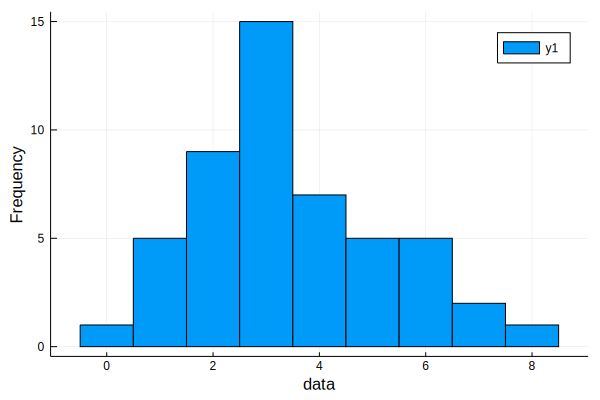

In [4]:
using Plots
histogram(data, bins=[-0.5:1:8.5;], xlabel="data", ylabel="Frequency")

ここまで植物個体ごとの種子数データを調べて以下のような特徴があることが分かりました：

* 1 個、 2 個、 ・・・と数えられるカウントデータ
* 1 個体の種子数の標本平均は 3.46 個
* 個体ごとに種子数にばらつきがあり、ヒストグラムを描くとひと山の分布になる

統計モデリングでは得られたデータを確率分布を用いて記述できるとみなします。これらの特徴を踏まえて（ポアソン分布から生成したものであるということを忘れたことにして）データを眺めていると、ポアソン分布が適しているのではないかという気がしてきます。

ポアソン分布は $\lambda$ という一つのでパラメータで平均と分散が定まります。ここでは「平均 3.46 のポアソン分布」を図示してみます：

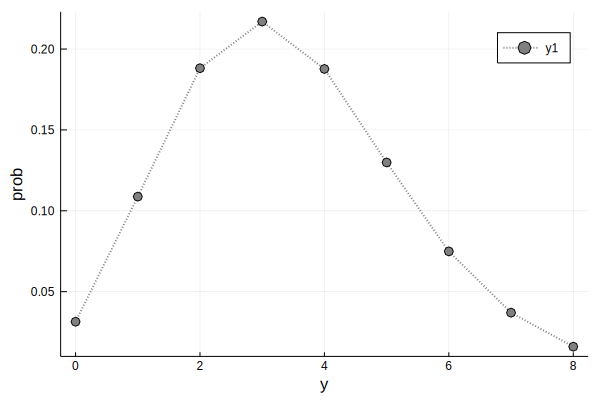

In [5]:
y = 0:8
prob = pdf.(Poisson(3.46), y)
plot(
    y,
    prob,
    color=:gray,
    line=(:dot, 2),
    marker=:o,
    ylabel="prob",
    xlabel="y"
)

このグラフを観測データのヒストグラムに重ねてみると、次のようなグラフになります。観測されたばらつきがポアソン分布で表現できているみたいだなぁという気がしてきました：

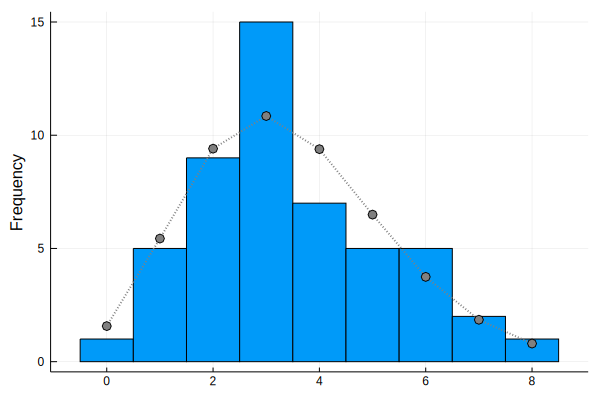

In [6]:
histogram(
    data,
    bins=[-0.5:1:8.5;],
    legend=false,
    ylabel="Frequency"
)
plot!(
    y,
    prob .* length(data),
    color=:gray,
    line=(:dot, 2),
    marker=:o
)

「図の見た目」による納得気分をもう少し定量的に示す方法として、ここでは**最尤推定**（maximum likelihood estimation）というパラメータ推定の方法を検討します。

### ポアソン分布のパラメータの最尤推定
最尤推定法は**尤度**なる「あてはまりの良さ」を表す統計量を最大にするようなパラメータ（ここの例題では $\lambda$）の値を探そうとするパラメータ推定方法です。尤度 $L(\lambda)$ はこのように定義されます：

$$
L(\lambda) = \prod_i p(y_i | \lambda) = \prod_i \frac{\lambda^{y_i}\exp(\lambda)}{y_i!}
$$

積になっているのは観測データが発生する同時確率を求めたいからですが、数が多くなるとこの値は 0 に急速に近づいていき計算が難しくなるので、対数変換した **対数尤度関数** (log likelihood function) を使います：

$$
\log L(\lambda) = \sum_i \log p(y_i | \lambda) = \sum_i \Biggl(y_i \log \lambda - \lambda - \sum_k^{y_i} \log k \Biggr)
$$

Juliia では Distributions の [`logpdf()` 関数](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.logpdf-Tuple{Distribution{Univariate,S}%20where%20S%3C:ValueSupport,Real}) を使うと簡単に $\log p(y_i | \lambda)$ を計算することができます：

In [7]:
logL = (m) -> sum(logpdf.(Poisson(m), data))

#3 (generic function with 1 method)

さきほどは観測データの標本平均を平均としたポアソン分布を当てはめてみましたが、 $\lambda$ を変化させていったときに、ポアソン分布の形と対数尤度がどのように変化するのか調べてみます：

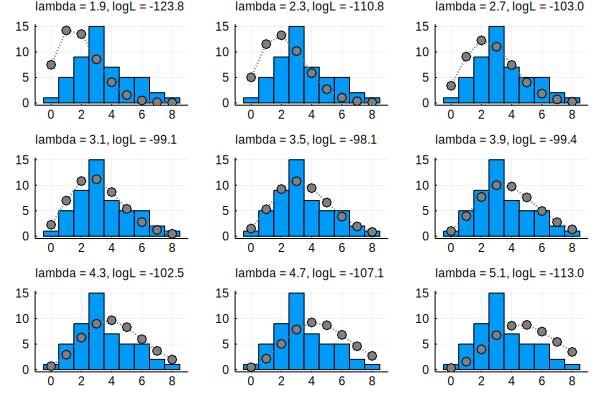

In [8]:
λs = 1.9:0.4:5.1
logLs = round.([logL(λ) for λ in λs], digits=1)
histogram(
    [data for _ in 1:length(λs)],
    bins=[-0.5:1:8.5;],
    legend=false,
    layout=(3,3),
    title=["lambda = $λ, logL = $(logLs[i])" for _ in 1:1, (i, λ) in enumerate(λs)],
    titlefont=font(8),
    titleloc=:left
)
plot!(
    y,
    [pdf.(Poisson(λ), y) .* length(data) for λ in λs],
    layout=(3,3),
    color=:gray,
    line=(:dot, 2),
    marker=:o
)

こうして眺めると確かに、対数尤度が大きい（ゼロに近い）ほど観測データとポアソン分布が「似ている」ように見えます。

では実際のところ、対数尤度は $\lambda$ がいくつのときに最大になるのでしょう。 [Optim](https://julianlsolvers.github.io/Optim.jl/stable/) パッケージを使って計算してみます（`optimize` は与えられた関数を最小化するので、 `logL` 関数に `-1` を掛けることで最大化しています）：

In [9]:
import Optim
Optim.optimize(x -> -logL(x), 2.0, 5.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [2.000000, 5.000000]
 * Minimizer: 3.460000e+00
 * Minimum: 9.811027e+01
 * Iterations: 10
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 11

3.46 のとき `logL` 関数が最大化されるようです。得られた `data` の平均値と一致していることが分かります。グラフを描いてみると確かに 3.46 付近で最大値を取っていることが確認できます:

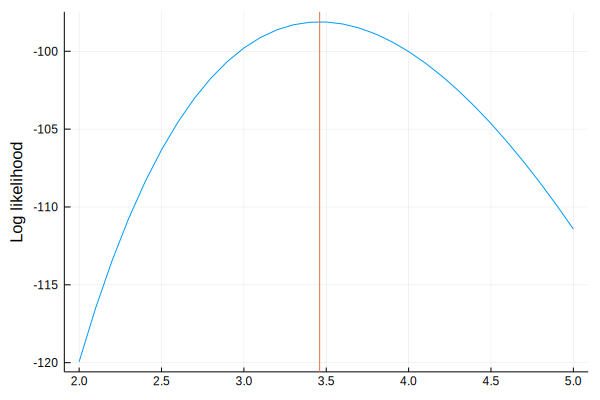

In [10]:
seq = 2:0.1:5
plot(seq, logL.(seq), legend=false, ylabel="Log likelihood", xticks=2:0.5:5)
vline!([3.46])

このように対数尤度が最大になるパラメータを**最尤推定量**（maximum likelihood estimator）、そして得られた値（今回であれば 3.46）を**最尤推定値**（maximum likelihood estimate）と呼びます。

### 最尤推定値のばらつき
今回のデータは Julia のポアソン乱数発生関数を使って作りました。一般に計算機に発生させる乱数は、真の意味での乱数ではないので、**疑似乱数**（pseudo random number）と呼ばれます。

乱数発生関数が生成する乱数列は毎回異なります。したがって、 50 個のポアソン乱数の標本平均も試行毎に異なります。乱数列を発生させる毎に、最尤推定値 $\hat{\lambda}$ はどのように変わるのか調べてみます：

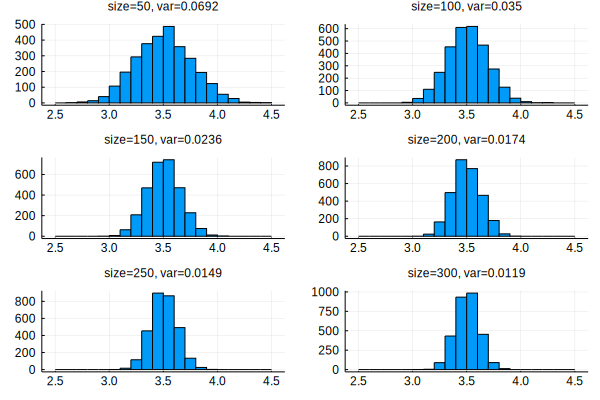

In [11]:
sizes = 50:50:300
means = [
     [mean(rand(Poisson(λ), size)) for _ in 1:3000]
    for size in sizes
]
histogram(
    means,
    bins=[2.5:0.1:4.5;],
    legend=false,
    layout=(3,2),
    titlefont=font(8),
    title=["size=$size, var=$(round(var(means[i]), digits=4))" for _ in 1:1, (i, size) in enumerate(sizes)]
)

推定値そのものがある程度ばらついていること、そして標本数が増えるに従って分散が小さくなっていっていることが分かります。このような推定値のばらつきは**標準誤差**とよばれます。

### 確率分布の選び方
観測データどえ解析する統計モデリングではまずどのような確率分布で説明できるかを考えます。次の点に注意しながらデータをみます：

* 離散か連続か？
* 有限か無限か？
* 標本分散と標本平均の関係は？

「データ解析のための統計モデリング入門」では以下の 4 つの確率分布を取り上げます：

* ポアソン分布：離散値、ゼロ以上の範囲、上限とくになし、平均≒分散
* 二項分布：離散値、ゼロ以上で有限の範囲、分散は平均の関数
* 正規分布：連続値、\[-∞, +∞\]、分散は平均とは無関係に決まる
* ガンマ分布：連続値、 \[0, +∞\]、分散は平均の関数

### まとめ
観測されたデータを説明するためにポアソン分布をあてはめ、最尤推定を用いてパラメータの推定を行いました。実際のデータでは、さまざまな確率分布が存在するので、データの特徴にあわせて確率分布を選ばなければなりません。そのためにも、まずは観測データをよく調べる必要があります。